# SeaHawk Processing

This Jupyter notebook show an example of processing a Level 2 NASA SeaHawk image and estimating Secchi depth and the Forel Ule colour. It based on code developed by Leon Ćatipović and modified by Bob Brewin.

## Step 1: Load relevant python packages

In [1]:
### STANDARD PACKAGES NEEDED###
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import xarray as xr
import astropy.coordinates as coord
from astropy.time import Time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Supresses outputs when trying to "divide by zero" or "divide by NaN" or "treatment for floating-point overflow"
#np.seterr(divide='ignore', over='ignore', invalid='ignore');
np.seterr(all='ignore');

## Step 2: Define functions needed for computations
Note at this stage the dimensions of the functions in the image are defined [5936,1800] inline with standard size of SeaHAWK images

### 2.1 Function to load Remote Sensing reflectnace ($R_{rs}$) from a SeaHAWK image
This function is for loading Rrs data from HawkEye .nc files and assigning data to numpy array and return

In [2]:
def load_rrs(string): 
    nc_file = xr.open_dataset(string, group = "geophysical_data")    
    Rrs_load = np.zeros((6, 5936, 1800)) # assign Rrs values based on the wavelength 
    Rrs_load[0,:,:] = nc_file.Rrs_412
    Rrs_load[1,:,:] = nc_file.Rrs_447
    Rrs_load[2,:,:] = nc_file.Rrs_488
    Rrs_load[3,:,:] = nc_file.Rrs_510
    Rrs_load[4,:,:] = nc_file.Rrs_556
    Rrs_load[5,:,:] = nc_file.Rrs_670
    return Rrs_load 

### 2.2 Apply the Raman correction following Lee et al. (2013) (https://doi.org/10.1002/jgrc.20308)
Inputs are Rrs and returns Raman-corrected Rrs

In [3]:
def raman_correction(Rrs_data): 
    RF = np.zeros((6, 5936, 1800))
    rrs_rc = np.zeros((6, 5936, 1800))
    x = np.array([412, 443, 488, 531, 551, 667])
    alpha = np.array([0.003, 0.004, 0.011, 0.015, 0.017, 0.018])
    beta1 = np.array([0.014, 0.015, 0.010, 0.010, 0.010, 0.010])
    beta2 = np.array([-0.022, -0.023, -0.051, -0.070, -0.080, -0.081])
    x1 = np.array([412, 447, 488, 510, 556, 670])
    alpha_1 = np.interp(x1, x, alpha)
    beta1_1 = np.interp(x1, x, beta1)
    beta2_1 = np.interp(x1, x, beta2)
    for i in range(0,6):
        RF[i] = alpha_1[i] * (Rrs_data[1]/Rrs_data[3]) + beta1_1[i] * (Rrs_data[3] ** beta2_1[i])
        rrs_rc[i] = Rrs_data[i]/(1+RF[i])
    return rrs_rc 

### 2.3 Compute Solar Zenith Angle

In [4]:
def calc_zenith(file_name): 
    nc1 = xr.open_dataset(file_name, group = "navigation_data")
    lats = nc1.latitude.data
    lons = nc1.longitude.data
    nums = file_name[17:32] ### ADJUST BASED ON THE FILE PATH!!!!!!!!!!!!!!!!!!
    datetime = nums[0:4] + "-" + nums[4:6] + '-' + nums[6:8] + ' ' + nums[9:11] + ":" + nums[11:13] + ':' + nums[13:] 
    sun_time = Time(datetime)
    loc = coord.EarthLocation(lon = lons, lat = lats)
    altaz = coord.AltAz(location = loc, obstime = sun_time)
    sun = coord.get_sun(sun_time)
    zen_ang = sun.transform_to(altaz).zen
    return zen_ang, lats, lons 

### 2.4 Apply the QAA algorithm to compute inherent optical properties from ($R_{rs}$)
This function applies the  QAAv6 algorithm (https://ioccg.org/wp-content/uploads/2020/11/qaa_v6_202011.pdf and https://ioccg.org/wp-content/uploads/2020/11/qaa_v6-202011.xlsm.zip). Inputs are from the nc_file and outputs are the total absorption and backscattering

In [5]:
def qaa(Rrs_data): #standard QAA algorithm, inputs Rrs
    ### STEP 1 ### caluclate rrs
    rrs = Rrs_data.copy()/(0.52 + 1.7 * Rrs_data.copy()) 
    rrs = np.where(rrs < 0, np.nan, rrs) # remove Laguna de Terminos, negative rrs, lot less data if you don't apply this
    ### STEP 2 ### calculate u
    u = (-0.089 + np.sqrt(0.089**2 + 4*0.1245*rrs.copy()))/(2*0.1245)
    ### STEP 3 ### calculate absorption for both cases of Rrs(670) < 0.0015
    x = np.log( (rrs[1].copy() + rrs[2].copy())/(rrs[4].copy() + (5 * rrs[5]**2/rrs[2])) )
    x = np.where(np.isinf(x), np.nan, x) # remove cases of devide by 0
    a556 = 0.0596 + np.power(10.0, -1.146 - 1.366 * x.copy() - 0.469 * x.copy()**2)        
    a670 = 0.439 + 0.39 * np.power( Rrs_data[5].copy()/(Rrs_data[1].copy() + Rrs_data[2].copy()), 1.14)  
    a670 = np.where(np.isinf(a670), np.nan, a670) # remove instances where Rrs(447) + Rrs(488) == 0
    ### STEP 4 ### calculate particulate backscattering for both cases of Rrs(670) < 0.0015
    bbp556 = (u[4].copy() * a556)/(1- u[4].copy()) - 3.5 * ((556/450)**(-4.32)) * 0.001 # Morel 1974 formula
    bbp670 = (u[5].copy() * a670)/(1- u[5].copy()) - 3.5 * ((670/450)**(-4.32)) * 0.001 # Morel 1974 formula
    ### STEP 5 ### calucalte exponent 
    n = 2 * (1 - 1.2 * np.exp(-0.9 * rrs[1].copy()/rrs[4].copy()))
    ### STEP 6 ### calculate particulate backscattering at all wavelengths 
    bbp = np.ones((6, 5936, 1800))
    bbp = bbp * np.nan
    wl = np.array([412, 447, 488, 510, 556, 670]) # HawkEye bands
    for i in range(0,6):
        bbp[i,:,:] = np.where(Rrs_data[5,:,:] < 0.0015, bbp556.copy() * np.power(556/wl[i].copy(), n),  bbp670.copy() * np.power(670/wl[i].copy(), n)) #  Morel 1974 formula
    ### STEP 7 ### calculate total absorption at all wavelengths 
    a = np.ones((6, 5936, 1800))
    a = a * np.nan
    bb = np.ones((6, 5936, 1800))
    bb = bb * np.nan 
    for i in range(0,6):
        a[i] = (1 - u[i].copy()) * (bbp[i].copy() + 3.50 * (wl[i].copy()/450)**(-4.32) * 10**(-3)) / u[i].copy()
        bb[i] = (bbp[i].copy() + 3.50 * (wl[i].copy()/450)**(-4.32) * 10**(-3)) # add purewater and particulate backscatter to calculate total backscattering
    return a, bb 

### 2.5 Apply the diffuse attenuation algroithm ($K_d$) of Lee et al. (2005) (https://doi.org/10.1029/2004JC002275)
Inputs absorption and backscattering from QAA

In [6]:
def kd_alg(a_data, bb_data, zen_angle): 
    kd_Lee = (1 + 0.005 * np.array(zen_angle)) * a_data + 4.18*(1-0.52*np.exp(-10.8*a_data))* bb_data 
    return kd_Lee 

### 2.6 Apply the Forel Ule algorithm following Pitarch et al (2019) (https://doi.org/10.1016/j.rse.2019.111249)
Inputs $R_{rs}$ data and the name of the image outputs Forel-Ule index (FUI), saves image under the name string and returns mapped FUI values.

In [7]:
def forel_ule(Rrs_data): 
    mx = np.array([2.957,0.112,14.354,10.861,1.711,58.356,3.744,5.672,28.227,3.455,21.929,3.967,52.304,59.454,0.682,32.825,17.810,0.018])
    mx = mx.reshape((3,6))
    xy = np.ones((2,5936, 1800))
    xy = xy * np.nan
    for i in range(0,5936):
        for j in range(0,1800):
            xyz = np.matmul(mx, Rrs_data[:,i,j]) 
            xy[0,i,j] = xyz[0]/(np.sum(xyz))
            xy[1,i,j] = xyz[1]/(np.sum(xyz))       
    xy = np.where(xy > 1, np.nan, xy)
    xy = np.where(xy < 0, np.nan, xy)        
    fui = np.array([0.191, 0.167, 0.199, 0.200, 0.210, 0.240, 0.227, 0.288, 0.246, 0.335, 0.266, 0.376, 0.291, 0.412, 0.315, 0.440, 0.337, 0.462, 0.363, 0.476, 0.386, 0.487, 0.402, 0.481, 0.416, 0.474, 0.431, 0.466, 0.446, 0.458, 0.461, 0.449, 0.475, 0.441, 0.489, 0.433, 0.503, 0.425, 0.516, 0.416, 0.528, 0.408])
    fui = fui.reshape((21,2))
    fui_map = np.ones((5936, 1800))
    fui_map = fui_map * np.nan
    for i in range(0,5936):
        for j in range(0,1800):
            if(~np.isnan(xy[0,i,j]) and ~np.isnan(xy[1,i,j])):
                dist_min = 999
                
                for t in range(0, 21):
                    dist = np.sqrt((xy[0,i,j] - fui[t,0])**2 + (xy[1,i,j] - fui[t,1])**2)
                    if dist < dist_min:
                        fui_map[i,j] = t + 1
                        dist_min = dist
    return (fui_map) 

### 2.7 Apply the Secchi depth algorithm following Lee et al. (2015) (https://doi.org/10.1016/j.rse.2015.08.002)
Inputs $R_{rs}$ data and $K_d$ data calculates secchi depth 

In [8]:
def secchi_alg(kd_data, Rrs_data): 
    kd_min = np.amin(kd_data, axis = 0) 
    kd_where = np.argmin(kd_data, axis = 0)
    Rrs_kd = np.ones((5936, 1800))  
    Rrs_kd = Rrs_kd * np.nan
    for i in range(0, 5936):
        for j in range(0, 1800):
            Rrs_kd[i,j] = Rrs_data[kd_where[i,j],i,j]
    z_sd_lee = np.log( np.abs(0.14 - Rrs_kd)/0.013 )/(2.5 * kd_min) 
    return z_sd_lee # returns secchi depth by Lee and approximation

## Step 3: Process example Image
Yucatan Peninsula, Mexico 11/12/2022 shoing river plumes and eddies. Example uses Raman-corrected $R_{rs}$
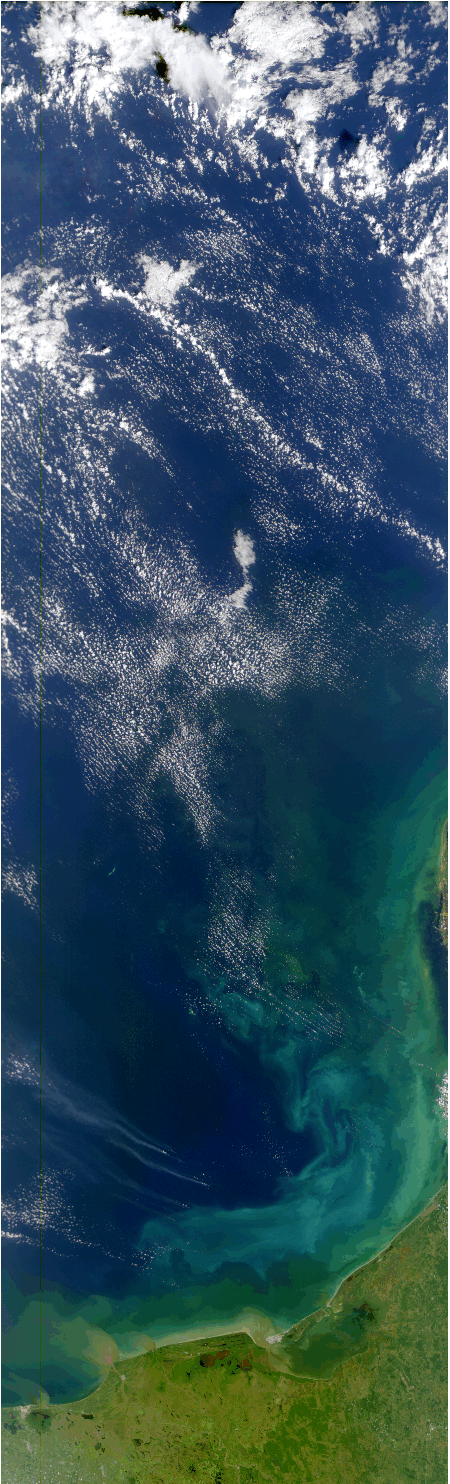

In [9]:
### LOAD .nc FILE ###
Rrs = load_rrs("SEAHAWK1_HAWKEYE.20221211T160629.L2.OC.nc")
zen, lats, lons  = calc_zenith("SEAHAWK1_HAWKEYE.20221211T160629.L2.OC.nc")

### RUN ALL CALCULATIONS with RAMAN CORRECTION ###
Rrs_rc = raman_correction(Rrs)
fui_map_r_c = forel_ule(Rrs_rc)
a, bp = qaa(Rrs_rc)
kd_L = kd_alg(a, bp, zen)
sd_rud_lee_rc = secchi_alg(kd_L, Rrs)

## Step 4: Plot results from example image
Note some slight interpolation of the original image by using contourf plotting function

In [ ]:
#Define size of plot
XSIZE = 25
YSIZE = 15
#Define the figure window including 2 subplots orientated horizontally
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(XSIZE,YSIZE), \
                gridspec_kw={'hspace': 0.25}, subplot_kw={'projection': ccrs.PlateCarree()})
#Plot Secchi map
IN_DATA        = sd_rud_lee_rc
PCT_1          = 0
PCT_2          = 50
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = np.nan
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = np.nan
im1 = ax1.contourf(lons, lats, IN_DATA, levels= np.linspace(0.0,50,12), cmap = "coolwarm", transform=ccrs.PlateCarree(), extend="max") 
fig.patch.set_facecolor('White')
ax1.set_title("Secchi Depth", fontsize=30) 
ax1.set_ylabel("Latitude", fontsize=30)
ax1.set_xlabel("Longitude", fontsize=30)
ax1.coastlines()
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='darkgray'))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlines = True
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params(nbins=9)
cbar1.set_label("[m]", size = 20)
cbar1.ax.tick_params(labelsize = 15)

#Plot FU map
#Creat colour bar
rgb = [[33, 88, 188],[49, 109, 197],[50, 124, 187],[75, 128, 160],[86, 143, 150],[109, 146, 152], \
       [105, 140, 134],[117, 158, 114],[123, 166, 84],[125, 174, 56],[149, 182, 69],[148, 182, 96],\
       [165, 188, 118],[170, 184, 109],[173, 181, 95],[168, 169, 101],[174, 159, 92],[179, 160, 83],\
       [175, 138, 68],[164, 105, 5],[161, 77, 4]]
rgb = np.array(rgb)/255.
val = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
cmap = matplotlib.colors.ListedColormap(rgb,"")
cmap.set_bad("black",1.)
norm = matplotlib.colors.BoundaryNorm(val,len(val))

IN_DATA        = fui_map_r_c
PCT_1          = 0
PCT_2          = 21
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = np.nan
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = np.nan
im2 = ax2.contourf(lons, lats, IN_DATA, levels= np.linspace(1, 21, 2*21 + 1), cmap = cmap, transform=ccrs.PlateCarree(), extend="max") 
fig.patch.set_facecolor('White')
ax2.set_title("Forel Ule Index", fontsize=30) 
ax2.set_ylabel("Latitude", fontsize=30)
ax2.set_xlabel("Longitude", fontsize=30)
ax2.coastlines()
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='darkgray'))
g2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='white', alpha=0.5, linestyle='--')
g2.top_labels = False
g2.bottom_labels = True
g2.left_labels = True
g2.right_labels = False
g2.xlines = True
g2.xlabel_style = {'size': 15}
g2.ylabel_style = {'size': 15}
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params(nbins=22)
cbar2.set_label("[FUI]", size = 20)
cbar2.ax.tick_params(labelsize = 15)
plt.show()